## Домашнее задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

## Решение:

Прежде всего установим библиотеку, которая содержит различные нейронные сети для сегментации изображений.

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 664.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=03bdb57426ce0995e434dbadec448c89ee631a470c7209ff36fa63fa53428f4d
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=5e82b61ef9d58a7c23378023a050a82fe6fdffff40e64ed0eeb02f574b437c3c
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


Сначала импортируем библиотеки, необходимые для дальнейшей работы.

In [2]:
import numpy as np
import pandas as pd
import os
import torch
import cv2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import albumentations as alb


from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

Сразу проведем проверку на наличие видеокарты.

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Посмотрим на примеры изображений и масок в изучаемом датасете.

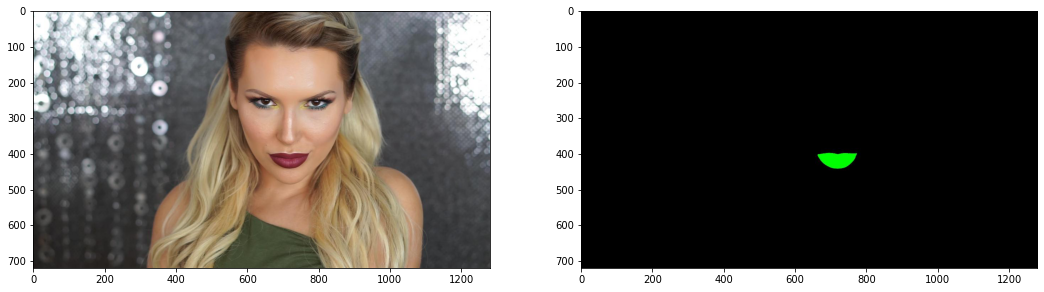

In [4]:
DATA_ROOT = '/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original'


img = plt.imread(DATA_ROOT + '/720p/image00000001.jpg')
mask = plt.imread(DATA_ROOT + '/mask/mask00000001.png')
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
axes[0].imshow(img)
axes[1].imshow(mask);

Составители указанного датасета сконцентрировались только на одном классе - губах. Поэтому в данном случае задачей будет сегментация губ на изображениях.

In [5]:
images = []
masks = []
for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            images.append(f)
        elif 'mask' in f:
            masks.append(f)

            
print(f'Количество изображений - {len(images)}.')
print(f'Количество масок - {len(masks)}.')

Количество изображений - 28594.
Количество масок - 28540.


Как видим масок меньше, чем изображений, поэтому важно учесть это при построении датасета.

Создадим датафрейм на основе csv файла с метаданными, который находится в одной директории вместе с изображениями/масками. В дальнейшем этот датафрейм будет базой для построения полноценного датасета, на котором будет обучаться нейронная сеть.

In [6]:
df = pd.read_csv(DATA_ROOT + '/list.csv')
df['img_filename'] = DATA_ROOT + '/720p/' + df['filename']
df['mask_filename'] = DATA_ROOT + '/mask/' + df['mask']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       28594 non-null  object
 1   width          28594 non-null  int64 
 2   height         28594 non-null  int64 
 3   class          28594 non-null  object
 4   xmin           28594 non-null  int64 
 5   ymin           28594 non-null  int64 
 6   xmax           28594 non-null  int64 
 7   ymax           28594 non-null  int64 
 8   mask           28594 non-null  object
 9   img_filename   28594 non-null  object
 10  mask_filename  28594 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.4+ MB


Создадим флаг, который будет проверять действительно ли есть маска для изображения в предоставленном датасете.

In [7]:
df['flag'] = df['mask_filename'].isin(masks)
df['flag'].value_counts()

True     28540
False       54
Name: flag, dtype: int64

Избавимся от изображений, для которых отсутствуют маски.

In [8]:
df.drop(df.loc[df['flag'] == False].index, axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28540 entries, 0 to 28593
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       28540 non-null  object
 1   width          28540 non-null  int64 
 2   height         28540 non-null  int64 
 3   class          28540 non-null  object
 4   xmin           28540 non-null  int64 
 5   ymin           28540 non-null  int64 
 6   xmax           28540 non-null  int64 
 7   ymax           28540 non-null  int64 
 8   mask           28540 non-null  object
 9   img_filename   28540 non-null  object
 10  mask_filename  28540 non-null  object
 11  flag           28540 non-null  bool  
dtypes: bool(1), int64(6), object(5)
memory usage: 2.6+ MB


Теперь создадим класс датасета для обработки и подготовки данных перед обучением.

In [9]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data['img_filename']
        # и на сегментированные картинки
        self.label_arr = self.data['mask_filename']
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализация
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)    
        mask = cv2.resize(mask, (512, 512))
        mask = np.asarray(mask).astype('float')
        mask = torch.as_tensor(mask) / 255.0  
        mask = mask.permute(2,0,1)
            
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

In [10]:
# создание модели
BACKBONE = 'resnet34'
segmodel = smp.PSPNet(BACKBONE, in_channels=3, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Посмотрим на пару изображение-маска, которые выдает датасет. Изображение в данном случае уже предобработано.

torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


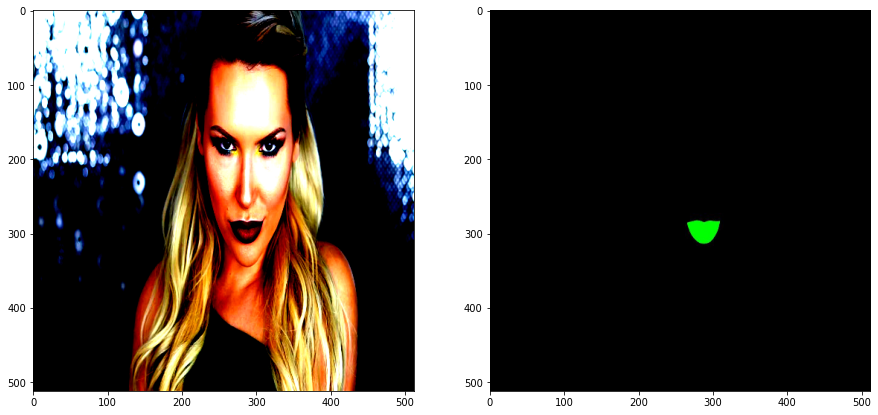

In [11]:
dataset = LipsDataset(df, preprocessing=preprocess_input)
img, mask = dataset[0]
print(img.shape, mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(mask.permute(1, 2, 0));

Сформируем тренировочную и тестовую выборки.

In [12]:
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LipsDataset(X_train, preprocessing=preprocess_input)
test_data = LipsDataset(X_test, preprocessing=preprocess_input)

Задаем метрику, лосс и оптимизатор.

In [13]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

Определим даталоадеры и генераторы по аналогии с представленными на лекции для облегчения процесса обучения.

In [14]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True,
    num_workers=2,
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

Переходим к обучению модели.

In [16]:
max_score = 0

for i in range(0, 3):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 2141/2141 [05:11<00:00,  6.87it/s, dice_loss - 0.06879, iou_score - 0.8729]
Model saved!
Epoch: 2
valid: 100%|██████████| 2141/2141 [04:50<00:00,  7.36it/s, dice_loss - 0.05162, iou_score - 0.9035]
Model saved!
Epoch: 3
valid: 100%|██████████| 2141/2141 [04:47<00:00,  7.43it/s, dice_loss - 0.05892, iou_score - 0.8909]


Посмотрим на визуальные результаты работы модели.

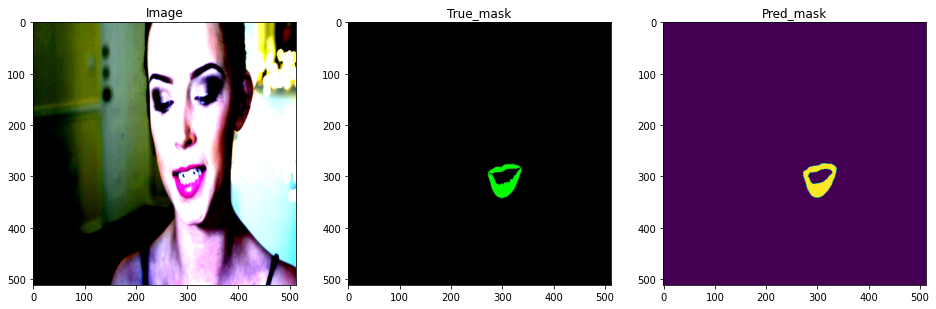

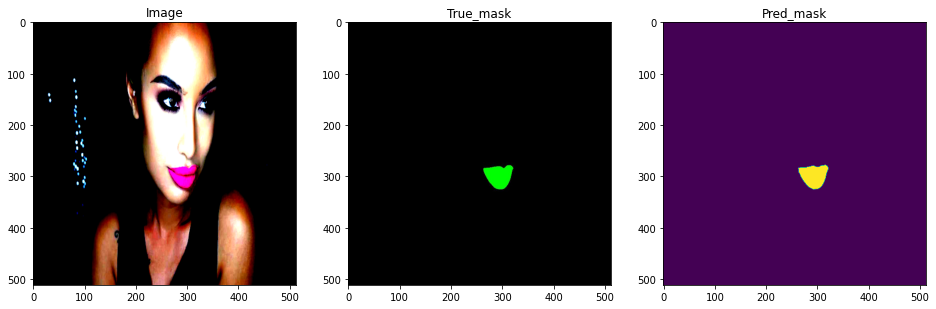

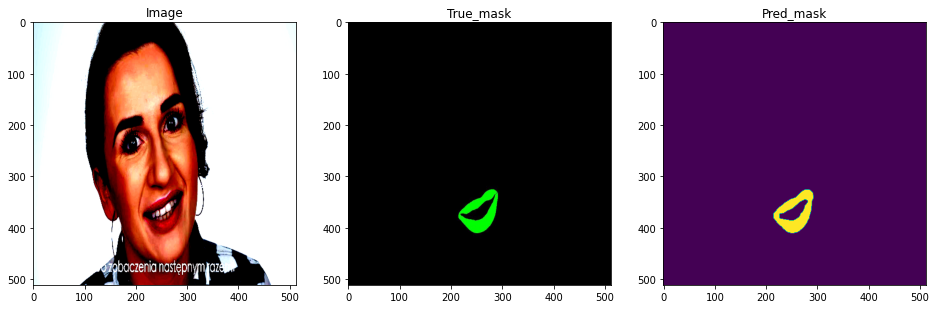

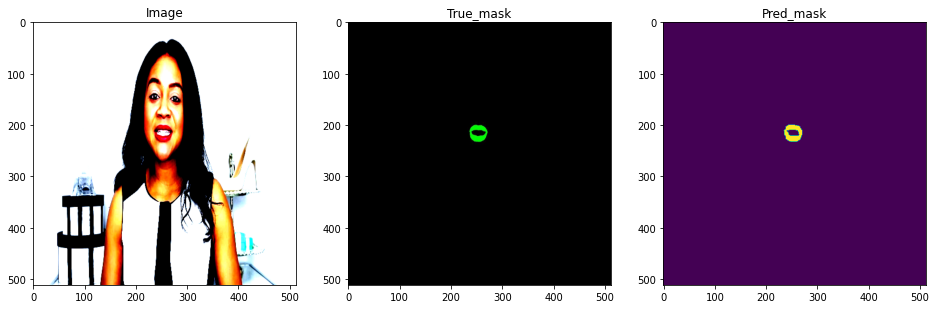

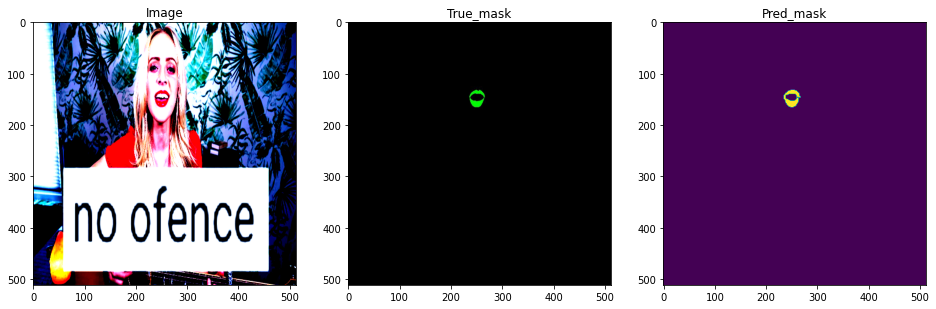

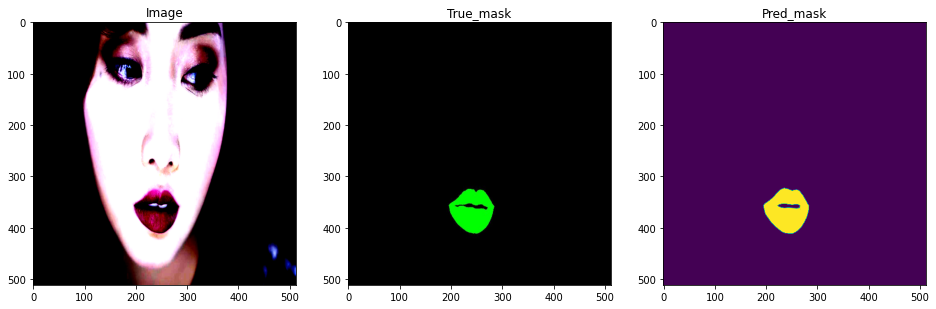

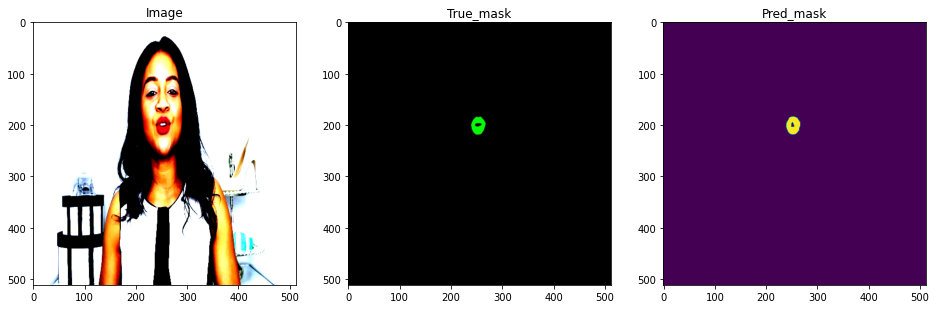

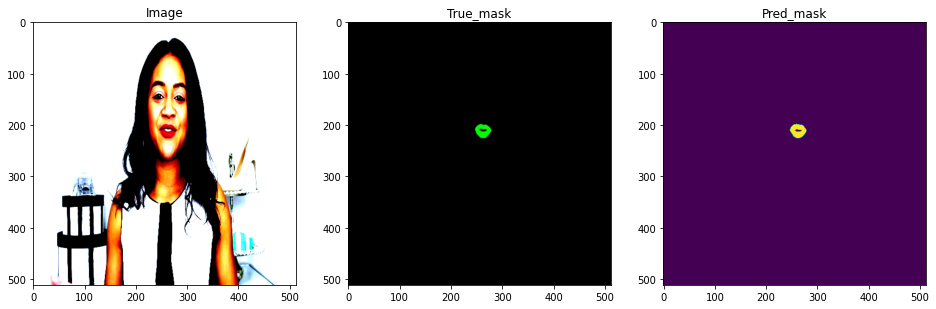

In [17]:
data_iter = iter(train_data_loader)
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')